<a href="https://colab.research.google.com/github/Galahexolion/Giliojo-mokymo-sistem-taikymai/blob/main/lab4/lab4_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Duomenų forma: (4600, 18)
                  date      price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0  2014-05-02 00:00:00   313000.0       3.0       1.50         1340      7912   
1  2014-05-02 00:00:00  2384000.0       5.0       2.50         3650      9050   
2  2014-05-02 00:00:00   342000.0       3.0       2.00         1930     11947   
3  2014-05-02 00:00:00   420000.0       3.0       2.25         2000      8030   
4  2014-05-02 00:00:00   550000.0       4.0       2.50         1940     10500   

   floors  waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
0     1.5           0     0          3        1340              0      1955   
1     2.0           0     4          5        3370            280      1921   
2     1.0           0     0          4        1930              0      1966   
3     1.0           0     0          4        1000           1000      1963   
4     1.0           0     0          4        1140            800      1976   

   yr_renova

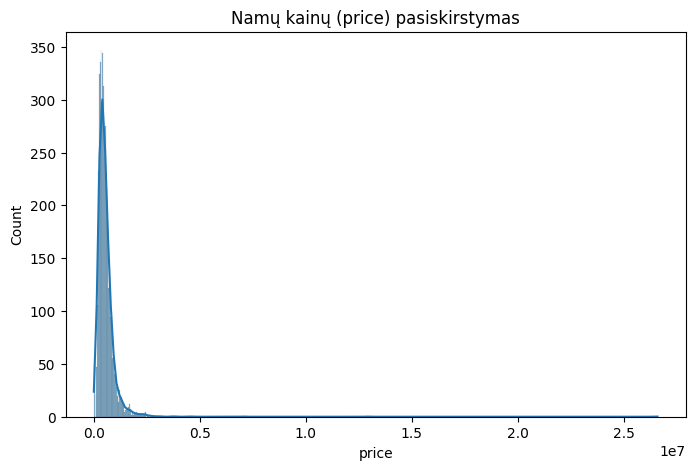

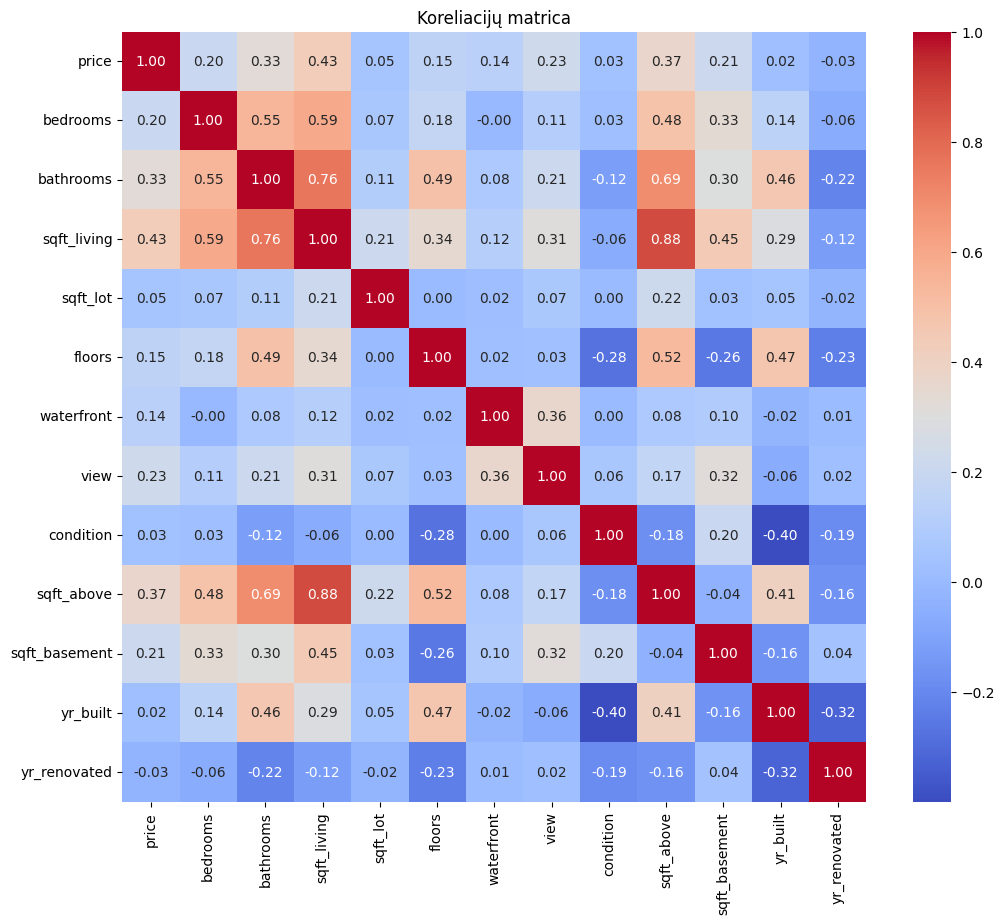

In [1]:
# --- 1. DATA IMPORT & EXPLORATION ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam

# Įkeliame jūsų įkeltą failą
df = pd.read_csv('data.csv')

print("Duomenų forma:", df.shape)
print(df.head())
print("\nStulpelių info:")
print(df.info())

# Patikriname trūkstamas reikšmes
print("\nTrūkstamos reikšmės:")
print(df.isnull().sum())

# Mūsų tikslas (Target) yra 'price'. Pažiūrėkime jo pasiskirstymą.
plt.figure(figsize=(8, 5))
sns.histplot(df['price'], kde=True)
plt.title('Namų kainų (price) pasiskirstymas')
plt.show()

# Koreliacijų matrica (tik skaitiniams stulpeliams)
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=[np.number]) # Atrenkame tik skaičius
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Koreliacijų matrica')
plt.show()

In [2]:
# --- 2. DATA PREPARATION ---

# Šiame rinkinyje yra nereikalingų stulpelių, kurie neturi įtakos kainai (pvz., 'date', 'street', 'country')
# Taip pat pašaliname kainą, nes ji yra mūsų tikslas.
# Pasiliekame tik logiškus skaitinius požymius (galima pridėti ir daugiau, jei koduotume tekstą)
features_to_use = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                   'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
                   'yr_built', 'yr_renovated']

X = df[features_to_use]
y = df['price']

# Daliname į Train/Test (80% / 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standartizuojame (svarbu neuroniniams tinklams)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nParuošti duomenys: {X_train_scaled.shape}")


Paruošti duomenys: (3680, 12)



--- Mokomas modelis: Simple ---
Simple Model MAE (Vidutinė paklaida): 262712.72

--- Mokomas modelis: Complex ---
Complex Model MAE (Vidutinė paklaida): 203364.30

--- Mokomas modelis: Regularized ---
Regularized Model MAE (Vidutinė paklaida): 204139.89


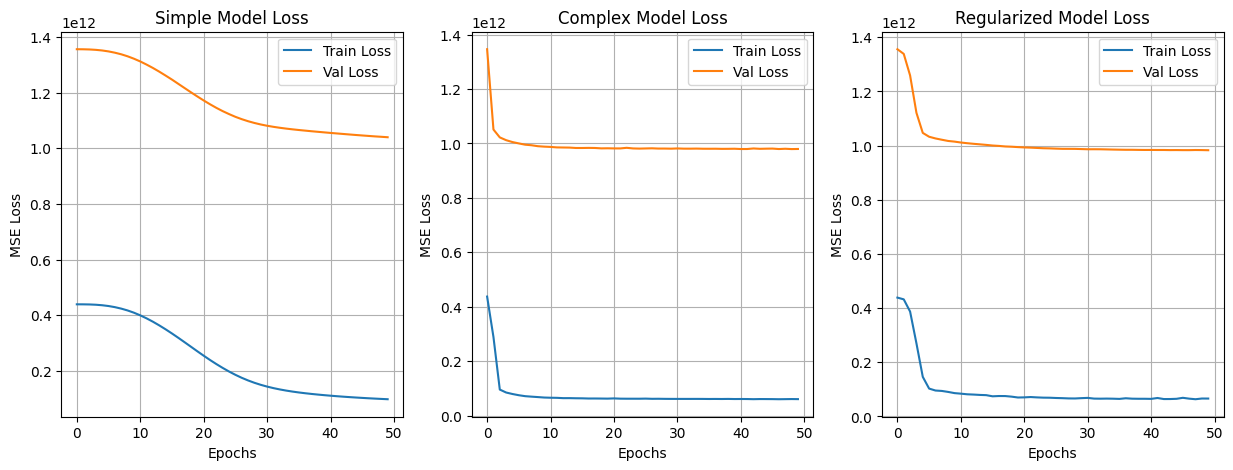

In [4]:
# --- 3. NEURAL NETWORK - 3 STRUCTURES ---

def create_regression_model(structure_type):
    model = Sequential()
    model.add(InputLayer(shape=(X_train_scaled.shape[1],)))

    if structure_type == "Simple":
        # 1. Paprastas tinklas
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))

    elif structure_type == "Complex":
        # 2. Sudėtingesnis tinklas
        model.add(Dense(256, activation='relu'))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))

    elif structure_type == "Regularized":
        # 3. Su Dropout (apsauga nuo permokymo)
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, activation='relu'))

    # Išėjimo sluoksnis: 1 neuronas, 'linear' aktyvacija (regresijai)
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

structures = ["Simple", "Complex", "Regularized"]
history_dict = {}
models_dict = {}

plt.figure(figsize=(15, 5))

for i, struct in enumerate(structures):
    print(f"\n--- Mokomas modelis: {struct} ---")
    model = create_regression_model(struct)

    # Mokome 50 epochų
    history = model.fit(X_train_scaled, y_train,
                        validation_data=(X_test_scaled, y_test),
                        epochs=50,
                        batch_size=32,
                        verbose=0)

    history_dict[struct] = history
    models_dict[struct] = model

    # Vertinimas
    mse, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"{struct} Model MAE (Vidutinė paklaida): {mae:.2f}")

    # Braižome Loss grafiką
    plt.subplot(1, 3, i+1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{struct} Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)

plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

--- Geriausio modelio (Complex) rezultatai ---
MSE: 979536292288.55
MAE (Vidutinė dolerių paklaida): 203364.30
R2 Score: 0.0395 (Kuo arčiau 1.0, tuo geriau)


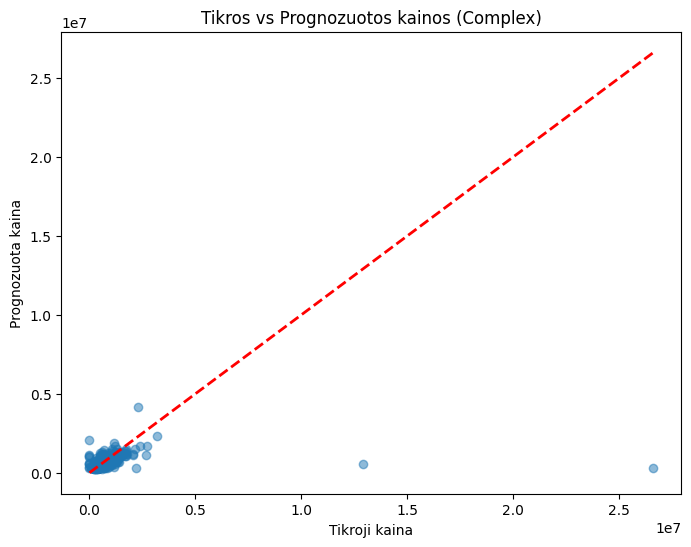

In [5]:
# --- 4. EVALUATION (Geriausias modelis) ---

best_model_name = "Complex" # Dažniausiai sudėtingesnis tinklas čia veikia geriau
model = models_dict[best_model_name]
y_pred = model.predict(X_test_scaled).flatten()

# Metrikos
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n--- Geriausio modelio ({best_model_name}) rezultatai ---")
print(f"MSE: {mse:.2f}")
print(f"MAE (Vidutinė dolerių paklaida): {mae:.2f}")
print(f"R2 Score: {r2:.4f} (Kuo arčiau 1.0, tuo geriau)")

# Vizualizacija: Tikra vs Prognozuota
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Tikroji kaina')
plt.ylabel('Prognozuota kaina')
plt.title(f'Tikros vs Prognozuotos kainos ({best_model_name})')
plt.show()